# Workshop - Structural Identifiability
## Model configuration for Cell Growth in a Bioreactor Setup

### Libraries

In [222]:
!pip install casadi scipy tqdm --quiet

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from scipy.interpolate import interp1d
from numpy.linalg import svd
import casadi as ca
from concurrent.futures import ProcessPoolExecutor
import pandas as pd

### Model Configuration

In [ ]:
nx = 3           # Number of state variables - all states are observed
                 # [0] Glc   - Glucose concentration
                 # [1] Lac   - Lactate concentration}
                 # [2] X     - Cell concentration
ny = 3           # Number of outputs (observed variables)                 
nth = 5          # Number of parameters used in the model
Tf = 218         # Final integration time [h], based on experimental data duration
Nt = 300         # Number of time evaluation points (can match number of data points or be higher)
t_eval = np.linspace(0, Tf, Nt)  # Time vector for integration

# === Symbolic variables for states and parameters ===
x = ca.MX.sym("x", nx)         # State vector: [Glc, Lac, X]
theta = ca.MX.sym("theta", nth)

# === Unpack parameters ===
r_glc, r_lac, mu_max, km_glc, ki_lac = theta[0], theta[1], theta[2], theta[3], theta[4]

# === Model constants ===
D_r = 0.017             # Dilution rate [1/h]
GF  = 0.131             # Feed concentration of Glucose [mM]

# === Algebraic equations ===
mu = mu_max * (x[0]/(km_glc + x[0])) * (ki_lac/(ki_lac + x[1]**2))  # Specific growth rate


# === Model definition ===
xdot = ca.vertcat(
    D_r * (GF - x[0]) - r_glc*x[2]*1e-6,                       # x[0] Glc
    -D_r * x[1] + r_lac*x[2]*1e-3,                             # x[1] Lac
    (mu - D_r) * x[2]                                          # x[2] Biomass (X)
)

# === Initial conditions as parameters (optional) ===
# You may keep these external, or define them as part of optimization later.
x0 = ca.MX.sym("x0", nx)

# === Nominal parameter values  ===
# r_glc, r_lac, mu_max, km_glc, ki_lac
theta_nom = np.array([0.032, 0.020, 0.078, 0.221, 10.954])

# === Fixed initial conditions ===
dx0_val = np.zeros((nx, nth))  # Sensitivities of x0 w.r.t. theta are zero

# === Symbolic derivatives for extended system ===
# These Jacobians define the structure of the sensitivity dynamics
dfdx = ca.jacobian(xdot, x)        # ∂f/∂x → state Jacobian
dfdth = ca.jacobian(xdot, theta)   # ∂f/∂θ → parameter Jacobian
dx0dth = ca.jacobian(x0, theta)    # ∂x₀/∂θ → initial sensitivity matrix

# === CasADi function wrappers ===
# These functions allow efficient numerical evaluation of the model and its derivatives
f = ca.Function("f", [x, theta], [xdot])                 # System dynamics
dfdx_fun = ca.Function("dfdx", [x, theta], [dfdx])       # Jacobian ∂f/∂x
dfdth_fun = ca.Function("dfdth", [x, theta], [dfdth])    # Jacobian ∂f/∂θ
dx0dth_fun = ca.Function("dx0dth", [theta], [dx0dth])    # ∂x₀/∂θ sensitivity matrix


# === Extended system: sensitivity ODEs ===
# Implements d(xθ)/dt = (∂f/∂x)·xθ + ∂f/∂θ
# Solves both the original system and the sensitivity dynamics

def meta_rhs(t, x_ext, theta_val):
    x = x_ext[:nx]
    dx_dth = x_ext[nx:].reshape((nx, nth))
    A = np.array(dfdx_fun(x, theta_val))        # ∂f/∂x evaluated at current state
    B = np.array(dfdth_fun(x, theta_val))       # ∂f/∂θ evaluated at current state
    dx = np.array(f(x, theta_val)).flatten()    # dx/dt
    d_dx_dth = A @ dx_dth + B                   # d(∂x/∂θ)/dt
    return np.concatenate([dx, d_dx_dth.flatten()])

# === Forward integration of state and sensitivities ===
# Solves the extended system using initial state and initial sensitivities

def simulate_once(theta_val):
    x0_val = np.array([1.01, 3.98, 0.46e6])                               # Initial state x₀(θ)
    dx0_val = np.zeros((nx, nth))                                         # Initial ∂x₀/∂θ
    x0_ext = np.concatenate([x0_val, dx0_val.flatten()])                  # Extended initial condition
    sol = solve_ivp(lambda t, x: meta_rhs(t, x, theta_val),
                t_span=(0, Tf), y0=x0_ext, method="BDF",
                rtol=1e-9, atol=1e-9, dense_output=True)
    y_dense = sol.sol(t_eval)
    x_out = y_dense[:nx, :].T
    dx_dth_out = y_dense[nx:, :].T.reshape(Nt, nx, nth)
    return t_eval, x_out, dx_dth_out

# === Sensitivity matrix computation (output) ===
# Implements: yθ = (∂h/∂x)·xθ + ∂h/∂θ
# In this model, h(x) = x₁(t), so ∂h/∂x = [1, 0] and ∂h/∂θ = 0

def compute_dydth(x_out, dx_dth_out, theta_val):

    # OSM: Output Sensitivity Matrix → dydth[i, j] = ∂y(t_i)/∂θ_j
    dydth = np.zeros((Nt * ny, nth))

    # ROSM: Relative Output Sensitivity Matrix → dydth_rel[i, j] = (∂y/∂θ)(θ_j / y(t))
    dydth_rel = np.zeros_like(dydth)

    # Store output values for optional plotting or normalization
    y_out = np.zeros((Nt, ny))

    for i in range(Nt):
        x_i = x_out[i]
        dx_i = dx_dth_out[i]
        for j in range(ny):
            y_out[i, j] = x_i[j]
            dydth_i = dx_i[j, :]
            dydth[i * ny + j] = dydth_i
            if x_i[j] != 0:
                dydth_rel[i * ny + j] = dydth_i * theta_val / x_i[j]
            else:
                dydth_rel[i * ny + j] = dydth_i * theta_val / np.mean(y_out[:, j])
    return dydth, dydth_rel, y_out


### Singular Value Decomposition

In [225]:
# === SVD ===
t_eval, x_out, dx_dth_out = simulate_once(theta_nom)
dydth, dydth_rel, y_out = compute_dydth(x_out, dx_dth_out, theta_nom)
U, S, Vh = svd(dydth_rel, full_matrices=False)

### Monte Carlo Analysis

In [ ]:
# === Limits configuration ===
# Sample parameter vectors around the nominal values
NExp = 100
theta_low = np.array([theta_nom[0]*0.001, 0.010, 0.056, 0.022, 1.890])
theta_high = np.array([0.228, 0.029, 0.368, 3.265, 36.099])

# Most of the time it is what we used to do for the parameter limits
# Uncomment the following lines if you want to use a simple scaling approach
#theta_low = 0.5 * theta_nom
#theta_high = 1.5 * theta_nom

# === Monte Carlo Analysis ===
THETA = np.random.uniform(theta_low, theta_high, size=(NExp, nth))
THETA[0] = theta_nom  # Ensure nominal parameters are included

# Start CPU time measurement
start_time = time.perf_counter()

# Storage arrays for singular values and nullspace vectors
SingularValues_list = []
V_last_cols_list = []

for k in range(NExp):
    theta_k = THETA[k]
    t_out, x_out, dx_dth_out = simulate_once(theta_k)
    dydth, dydth_rel, _ = compute_dydth(x_out, dx_dth_out, theta_k)

    U, S, Vh = svd(dydth_rel, full_matrices=False)
    if S.shape[0] == nth:
        SingularValues_list.append(S)
        V_last_cols_list.append(Vh[-1])
    else:
        print(f"Saltando experimento {k} por tamaño incorrecto: {S.shape}")

SingularValues = np.array(SingularValues_list)
V_last_cols = np.array(V_last_cols_list).T  # transpuesta para mantener forma (nth, Nvalid)


# End CPU time measurement
elapsed_time = time.perf_counter() - start_time
avg_time_per_exp = elapsed_time / NExp

print(f"Monte Carlo analysis completed in {elapsed_time:.2f} seconds.")
print(f"Average time per experiment: {avg_time_per_exp:.2f} seconds.")

### Plots for Monte Carlo Analysis

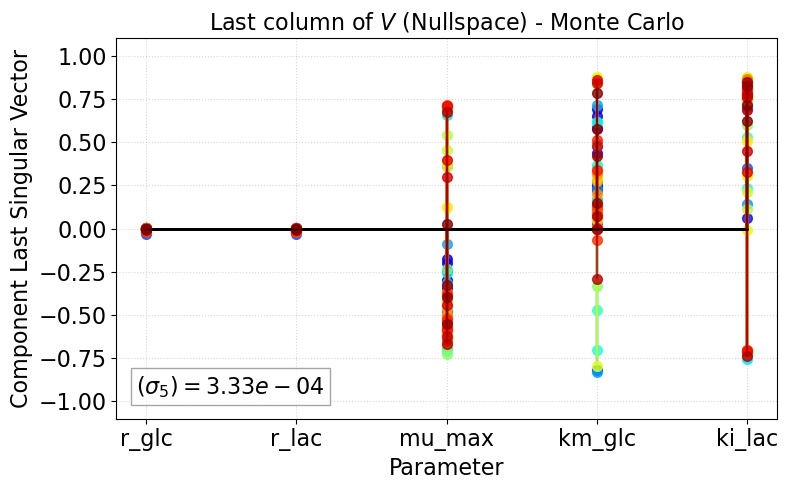

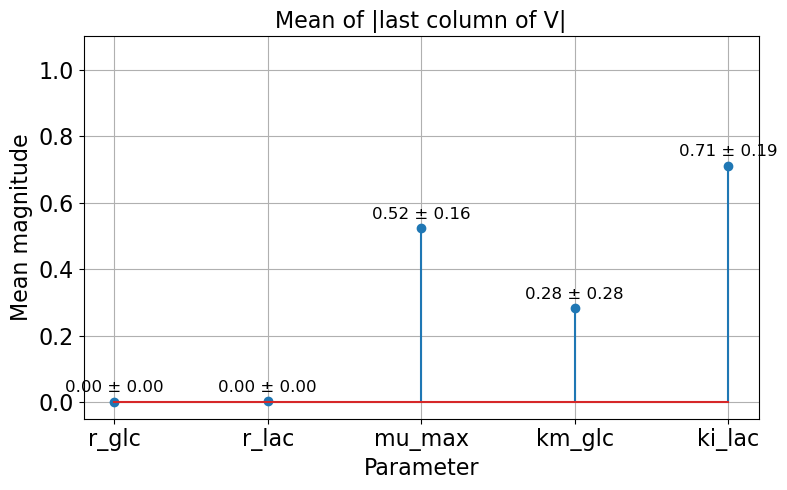

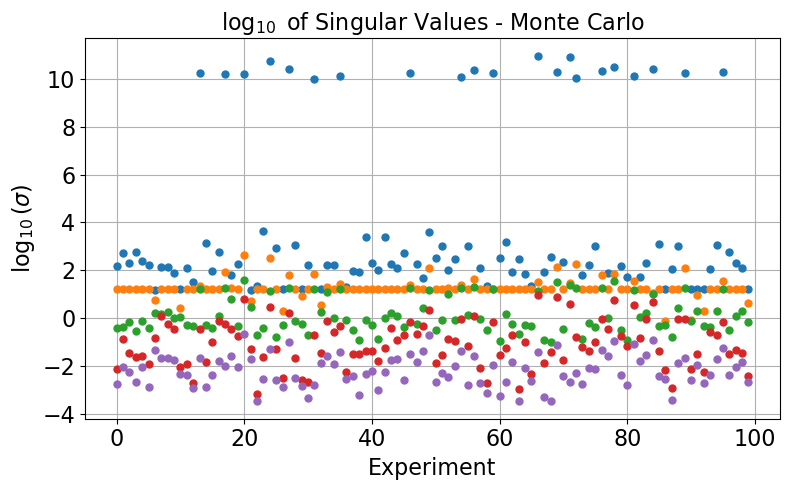


=== Fixing Analysis from Nullspace ===
Contribution threshold: |v_i| > 0.30
Parameters with strong contribution (candidates):
 - mu_max: |v_i| ≈ 0.52
 - ki_lac: |v_i| ≈ 0.71


In [228]:
# Compute mean and standard deviation of nullspace components
mean_v = np.mean(np.abs(V_last_cols), axis=1)
std_v = np.std(np.abs(V_last_cols), axis=1)
min_sigma = np.min(SingularValues[:, -1])
max_sigma = np.max(SingularValues[:, 0])
last_v = mean_v

# === Plot: Last column of V for each experiment ===
param_names = ['r_glc', 'r_lac', 'mu_max', 'km_glc', 'ki_lac']
x_vals = np.arange(nth)
colors = plt.cm.jet(np.linspace(0, 1, NExp))

plt.figure(figsize=(8, 5))
for k in range(NExp):
    v_last = V_last_cols[:, k]
    markerline, stemlines, baseline = plt.stem(
        x_vals, v_last,
        linefmt='-', markerfmt='o', basefmt='k-',
        label=f'Exp {k+1}'
    )
    plt.setp(markerline, color=colors[k], markersize=7, alpha=0.8)
    plt.setp(stemlines, color=colors[k], linewidth=1.6, alpha=0.8)
    plt.setp(baseline, color='k', linewidth=1.0, alpha=0.7)

plt.xticks(x_vals, param_names, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.title(r"Last column of $V$ (Nullspace) - Monte Carlo", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel(r"Component Last Singular Vector", fontsize=16)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle=':', alpha=0.5)

plt.text(
    0.03, 0.05,
    rf'$(\sigma_{{{nth}}}) = {min_sigma:.2e}$',
    fontsize=16,
    transform=plt.gca().transAxes,
    ha='left', va='bottom',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)

plt.tight_layout()
plt.show()

# === Plot: Mean of |last column of V| ===
plt.figure(figsize=(8, 5))
plt.stem(mean_v)
plt.xticks(x_vals, param_names, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
for i in range(nth):
    plt.text(i, mean_v[i] + 0.02, f"{mean_v[i]:.2f} ± {std_v[i]:.2f}", ha='center', va='bottom', fontsize=12)

plt.title("Mean of |last column of V|", fontsize=16)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel("Mean magnitude", fontsize=16)
plt.ylim(-0.05, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: log10 of singular values across experiments ===
plt.figure(figsize=(8, 5))
plt.plot(np.log10(SingularValues), '.', markersize=10)
plt.title(r"$\log_{10}$ of Singular Values - Monte Carlo", fontsize=16)
plt.xlabel("Experiment", fontsize=16)
plt.ylabel(r"$\log_{10}(\sigma)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Fixed Parameters Analysis from last column of V (Nullspace) ---

# Threshold for "strong" contribution in the nullspace vector
umbral_contribucion = 0.3

# Last column of mean V, already calculated by Monte Carlo (mean over |last V| per experiment)
# Assuming mean_v = np.mean(np.abs(V_last_cols), axis=1)
last_V_abs = mean_v  # Vector with absolute contributions averaged over experiments


# Parameters indexes with strong contribution
indices_candidatos = np.where(last_V_abs > umbral_contribucion)[0]
param_candidatos = [param_names[i] for i in indices_candidatos]

# Analysis of parameters candidates for fixing
print("\n=== Fixing Analysis from Nullspace ===")
print(f"Contribution threshold: |v_i| > {umbral_contribucion:.2f}")
print("Parameters with strong contribution (candidates):")
for i in indices_candidatos:
    print(f" - {param_names[i]}: |v_i| ≈ {last_V_abs[i]:.2f}")

if len(indices_candidatos) == 0:
    print(" There's no parameters with sufficiently high contribution to suggest fixing.")


### Model dynamics

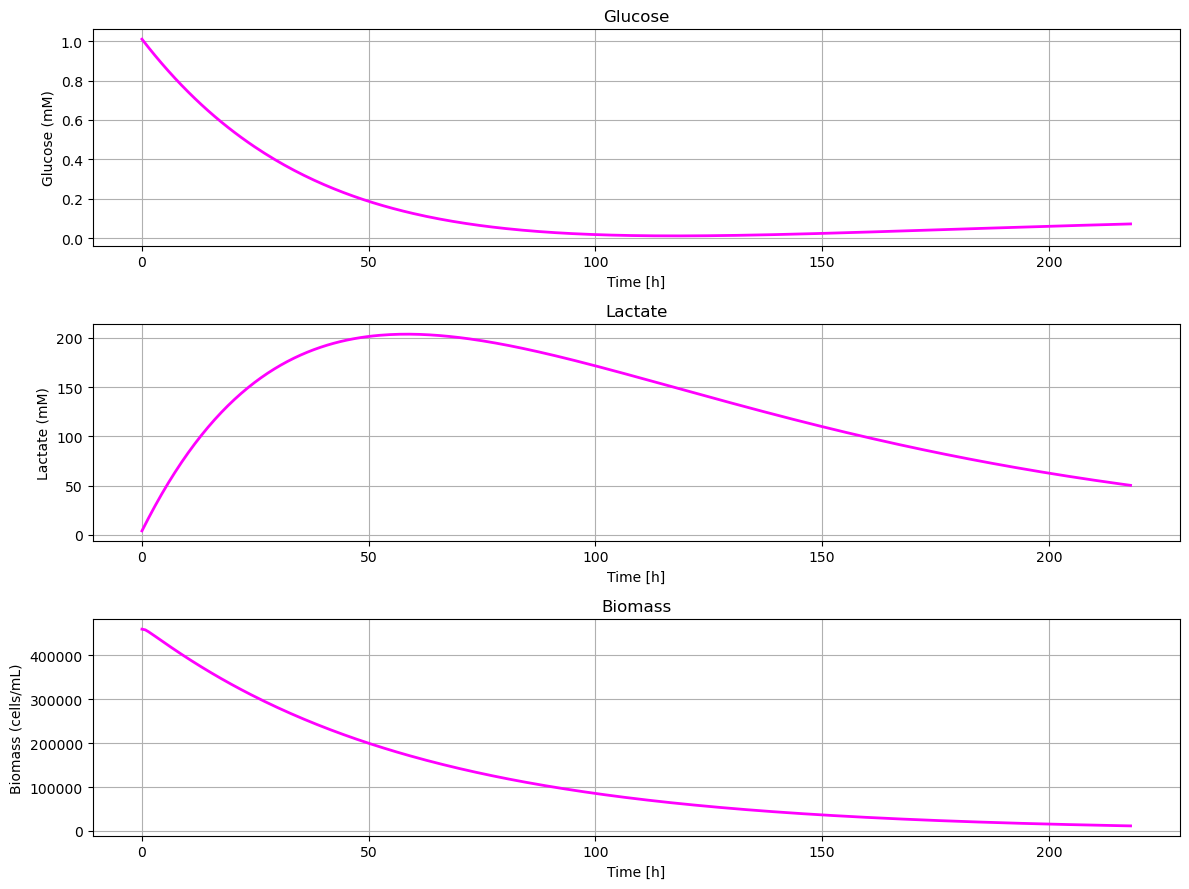

In [ ]:
t_out, x_out, dx_dth_out = simulate_once(theta_nom)
observed_indices = [0, 1, 2,]
observed_labels = ['Glucose', 'Lactate', 'Biomass']

# Convertir resultados
_, _, y_out = compute_dydth(x_out, dx_dth_out, theta_nom)

# Plot 3x2
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 9))
axs = axs.flatten()

for i in range(3):
    axs[i].plot(t_out, y_out[:, i], color='magenta', linewidth=2)
    axs[i].set_title(observed_labels[i])
    axs[i].set_xlabel("Time [h]")

    # Asignar unidad específica
    if i == 2:
        axs[i].set_ylabel(f"{observed_labels[i]} (cells/mL)")  # Biomass
    else:
        axs[i].set_ylabel(f"{observed_labels[i]} (mM)")         # Glucose y Lactate

    axs[i].grid(True)

plt.tight_layout()
plt.show()


### Experimental Data

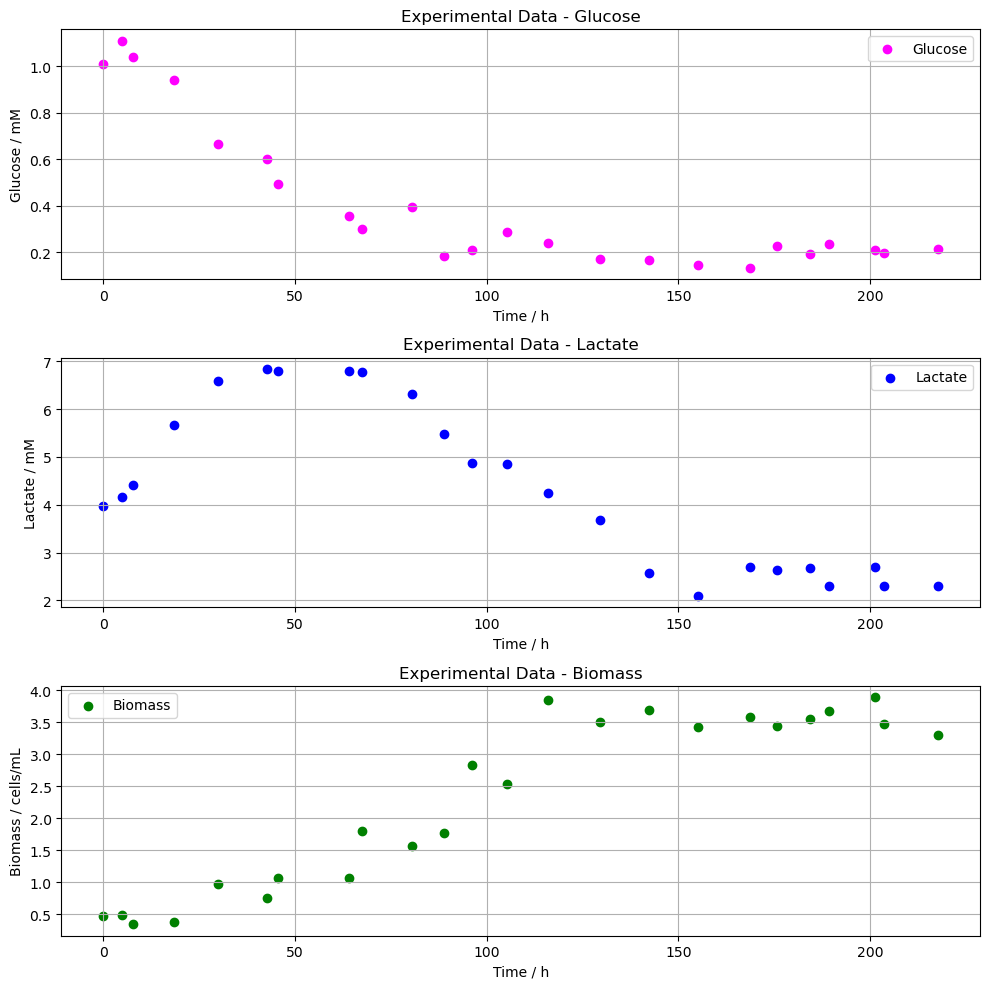

In [230]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Leer archivo
data_file = 'Model2Data.csv'
df = pd.read_csv(data_file, sep=',', header = 0)
df.columns = ["Time", "X", "Glucose", "Lactate"]
df = df.astype(float)

# Extraer variables
t_exp      = df["Time"].to_numpy()
biomass    = df["X"].to_numpy()
glc        = df["Glucose"].to_numpy()
lac        = df["Lactate"].to_numpy()

# Gráfico 3x1 con puntos
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].scatter(t_exp, glc, color='magenta', label="Glucose")
axs[0].set_ylabel("Glucose / mM")
axs[0].legend()
axs[0].set_title("Experimental Data - Glucose")

axs[1].scatter(t_exp, lac, color='blue', label="Lactate")
axs[1].set_ylabel("Lactate / mM")
axs[1].legend()
axs[1].set_title("Experimental Data - Lactate")

axs[2].scatter(t_exp, biomass, color='green', label="Biomass")
axs[2].set_ylabel("Biomass / cells/mL")
axs[2].legend()
axs[2].set_title("Experimental Data - Biomass")

# Estética común
for ax in axs.flat:
    ax.set_xlabel("Time / h")
    ax.grid(True)

plt.tight_layout()
plt.show()